In [78]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, TimeDistributed, Input, merge, Merge
from keras.layers.embeddings import Embedding
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.optimizers import SGD, Adam
from keras.callbacks import Callback, EarlyStopping

import util
import util_chris

In [114]:
vocab_size = 50000
max_review_length = 500
embedding_vector_length = 0
dropout_rate = 0.2
max_size = 110

In [121]:
reload(util_chris)

<module 'util_chris' from 'util_chris.py'>

In [122]:
# sentences, what_labels, buys_labels, uses_labels, supplies_labels = util.load_data(vocab_size, max_review_length)
x, whats, buys, supplies = util_chris.get_examples(w2v = True, max_size = max_size)
X_train, X_test, y_train, y_test = train_test_split(x, whats, test_size = 0.33)
class_rebalance = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [104]:
print len(X_train)
print len(X_train[0])
print len(X_train[0][0])

55927
110
100


# Simple LSTM

In [115]:
model = Sequential()
model.add(LSTM(100, input_shape = (max_size,100)))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_71 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 101       
Total params: 80,501
Trainable params: 80,501
Non-trainable params: 0
_________________________________________________________________
None


In [116]:
optimizer = Adam(lr=0.0005, decay=0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
genhistory = util.GenHistory()
history = model.fit(X_train, y_train, class_weight = class_rebalance,
                      validation_data=(X_test, y_test), 
                      epochs=3, batch_size=64, verbose = 1,
                      callbacks = [genhistory])

Train on 55927 samples, validate on 27547 samples
Epoch 1/3
55927/55927 [==============================] - 181s - loss: 0.4921 - acc: 0.7590 - val_loss: 0.4658 - val_acc: 0.7876
Epoch 2/3
45568/55927 [=======================>......] - ETA: 27s - loss: 0.4605 - acc: 0.7886

KeyboardInterrupt: 

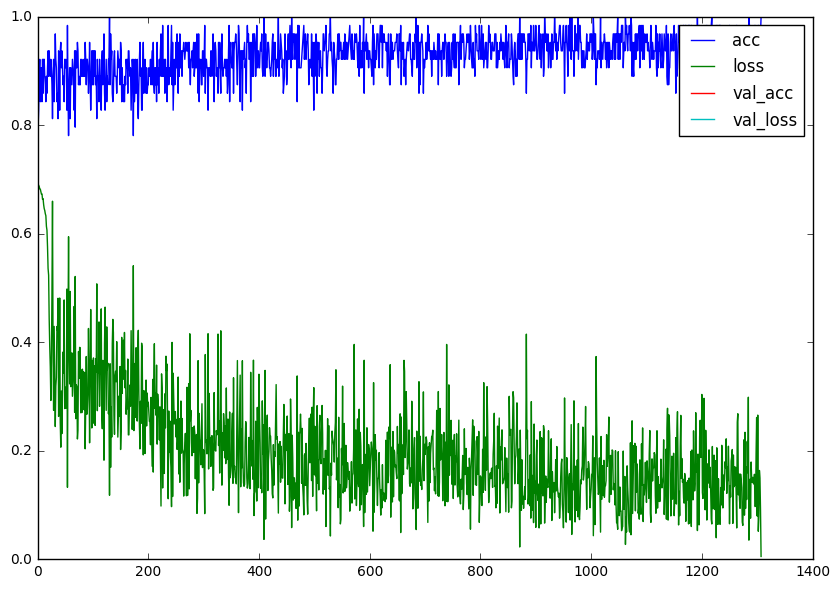

In [6]:
reload(util)
util.plot_genhistory(genhistory)

# Double LSTM

In [9]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
model.add(Dropout(dropout_rate))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=0.0005, decay=0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
genhistory = util.GenHistory()
history = model.fit(X_train, y_train, class_weight = class_rebalance,
                      validation_data=(X_test, y_test), 
                      epochs=3, batch_size=64, verbose = 1,
                      callbacks = [genhistory])

Train on 27842 samples, validate on 13714 samples
Epoch 1/3
27842/27842 [==============================] - 808s - loss: 0.2713 - acc: 0.9091 - val_loss: 0.2067 - val_acc: 0.9267
Epoch 2/3
27842/27842 [==============================] - 807s - loss: 0.1739 - acc: 0.9375 - val_loss: 0.2100 - val_acc: 0.9293
Epoch 3/3
27842/27842 [==============================] - 809s - loss: 0.1464 - acc: 0.9485 - val_loss: 0.2056 - val_acc: 0.9247


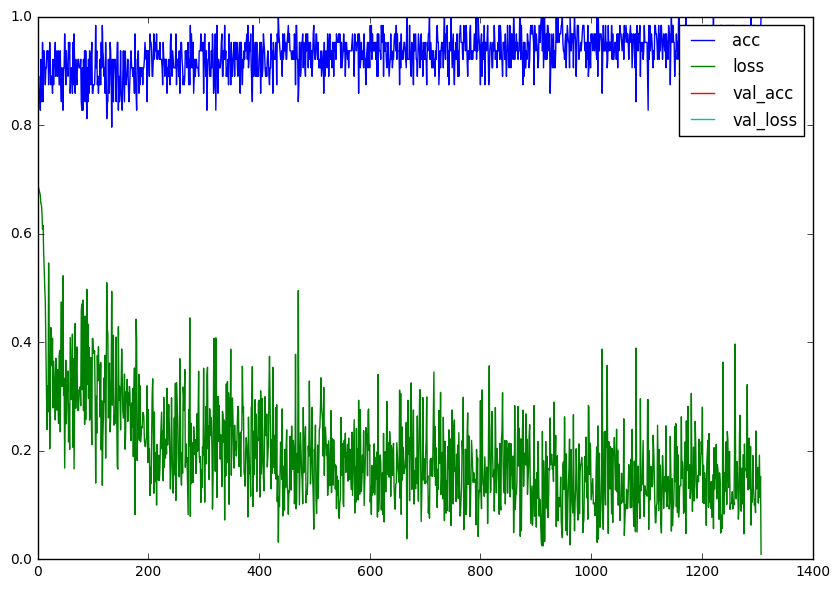

In [10]:
reload(util)
util.plot_genhistory(genhistory)

# BLTSM mean

In [101]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
model.add(Dropout(dropout_rate))
model.add(Bidirectional(LSTM(100), merge_mode = 'ave'))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=5e-4, decay=0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_58 (Embedding)     (None, 500, 200)          10000000  
_________________________________________________________________
dropout_61 (Dropout)         (None, 500, 200)          0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 100)               240800    
_________________________________________________________________
dropout_62 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 101       
Total params: 10,240,901
Trainable params: 10,240,901
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
genhistory = util.GenHistory()
history = model.fit(X_train, y_train, class_weight = class_rebalance,
                      validation_data=(X_test, y_test), 
                      epochs=3, batch_size=64, verbose = 1,
                      callbacks = [genhistory])

Train on 27842 samples, validate on 13714 samples
Epoch 1/3
27842/27842 [==============================] - 634s - loss: 0.2795 - acc: 0.9016 - val_loss: 0.1993 - val_acc: 0.9270
Epoch 2/3
27842/27842 [==============================] - 619s - loss: 0.1844 - acc: 0.9319 - val_loss: 0.1893 - val_acc: 0.9320
Epoch 3/3
27842/27842 [==============================] - 635s - loss: 0.1494 - acc: 0.9470 - val_loss: 0.1911 - val_acc: 0.9297


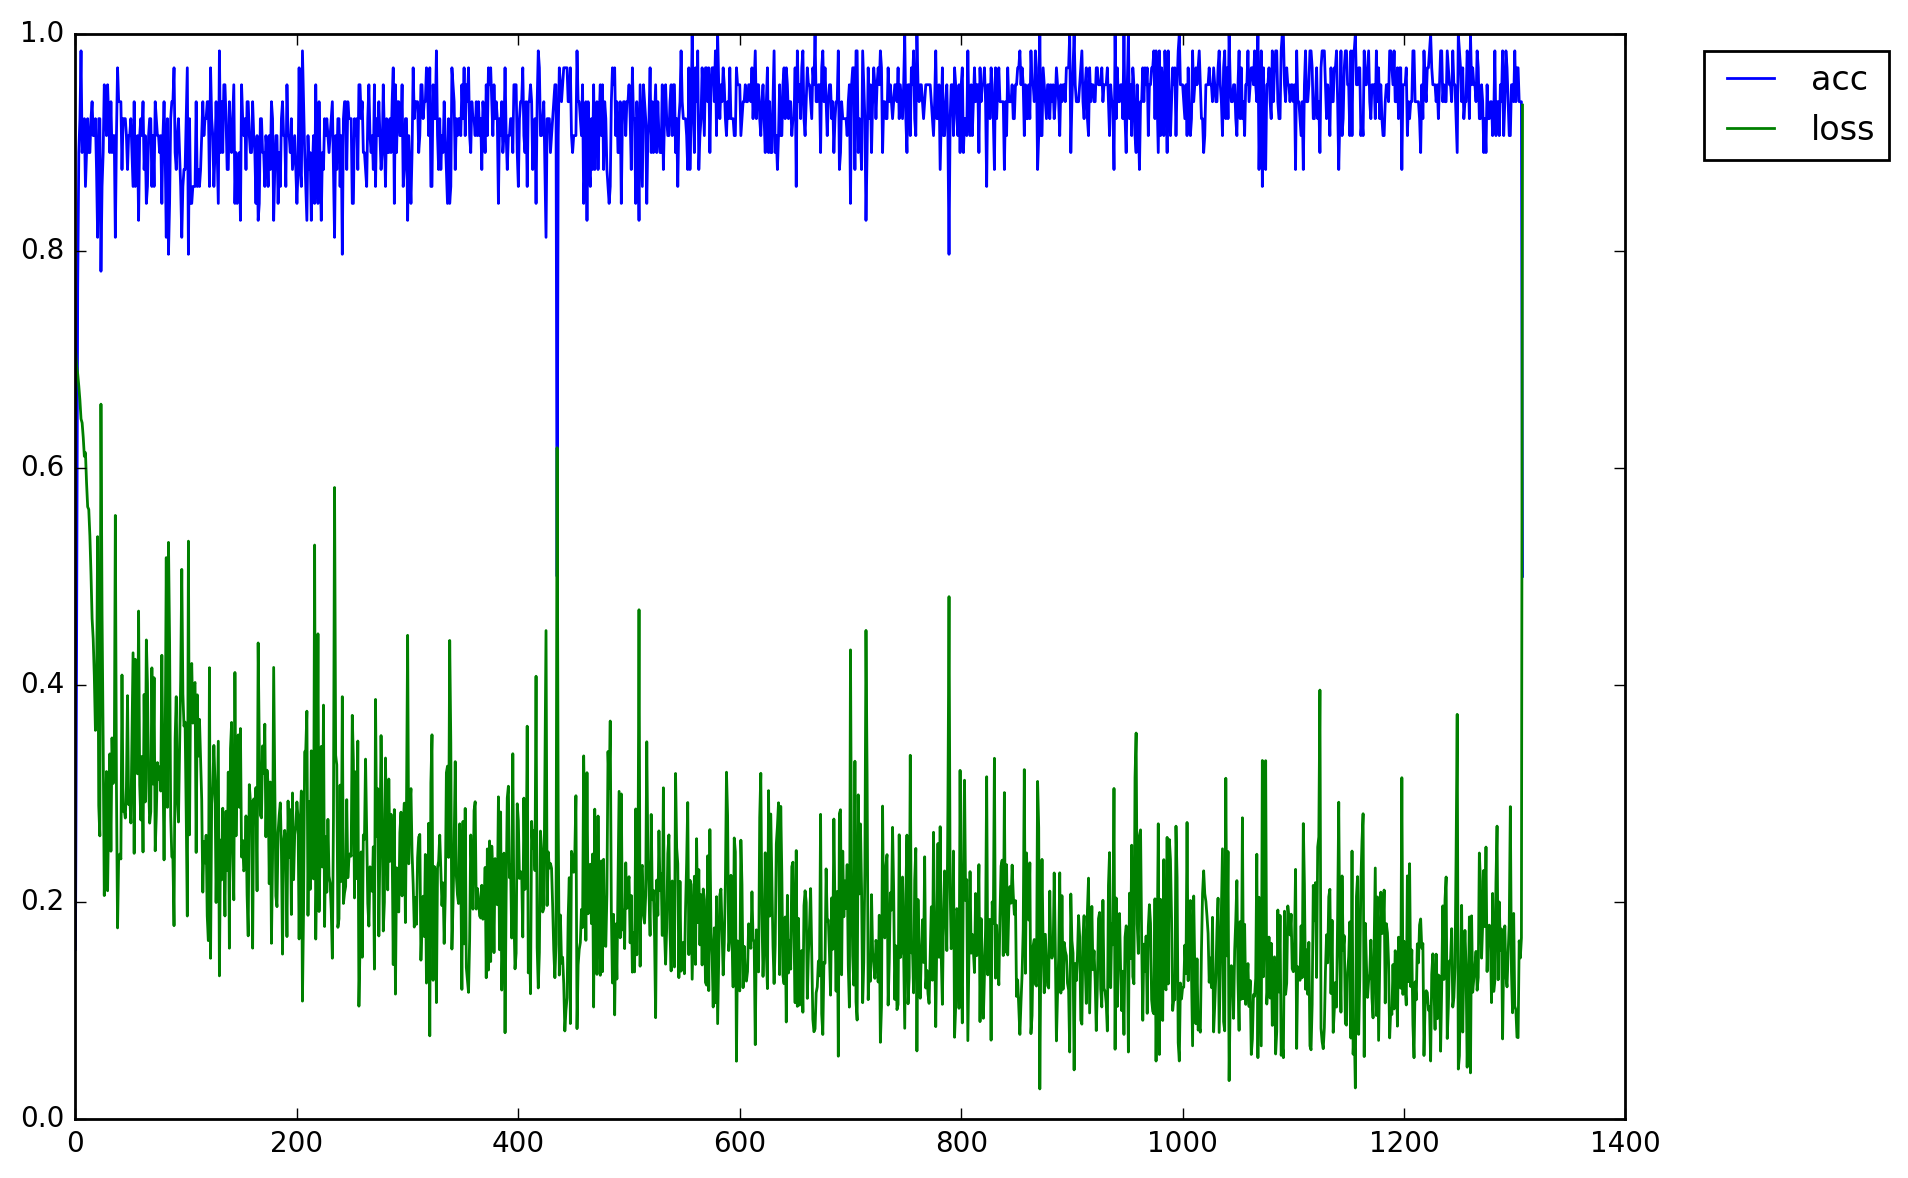

In [77]:
reload(util)
util.plot_genhistory(genhistory)

# BLTSM concat

In [75]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
model.add(Dropout(dropout_rate))
model.add(Bidirectional(LSTM(100), merge_mode = 'concat'))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=5e-4, decay=0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, 500, 200)          10000000  
_________________________________________________________________
dropout_59 (Dropout)         (None, 500, 200)          0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 100)               240800    
_________________________________________________________________
dropout_60 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 101       
Total params: 10,240,901
Trainable params: 10,240,901
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
genhistory = util.GenHistory()
history = model.fit(X_train, y_train, class_weight = class_rebalance,
                      validation_data=(X_test, y_test), 
                      epochs=3, batch_size=64, verbose = 1,
                      callbacks = [genhistory])

Train on 27842 samples, validate on 13714 samples
Epoch 1/3
 2112/27842 [=>............................] - ETA: 630s - loss: 0.4789 - acc: 0.8632

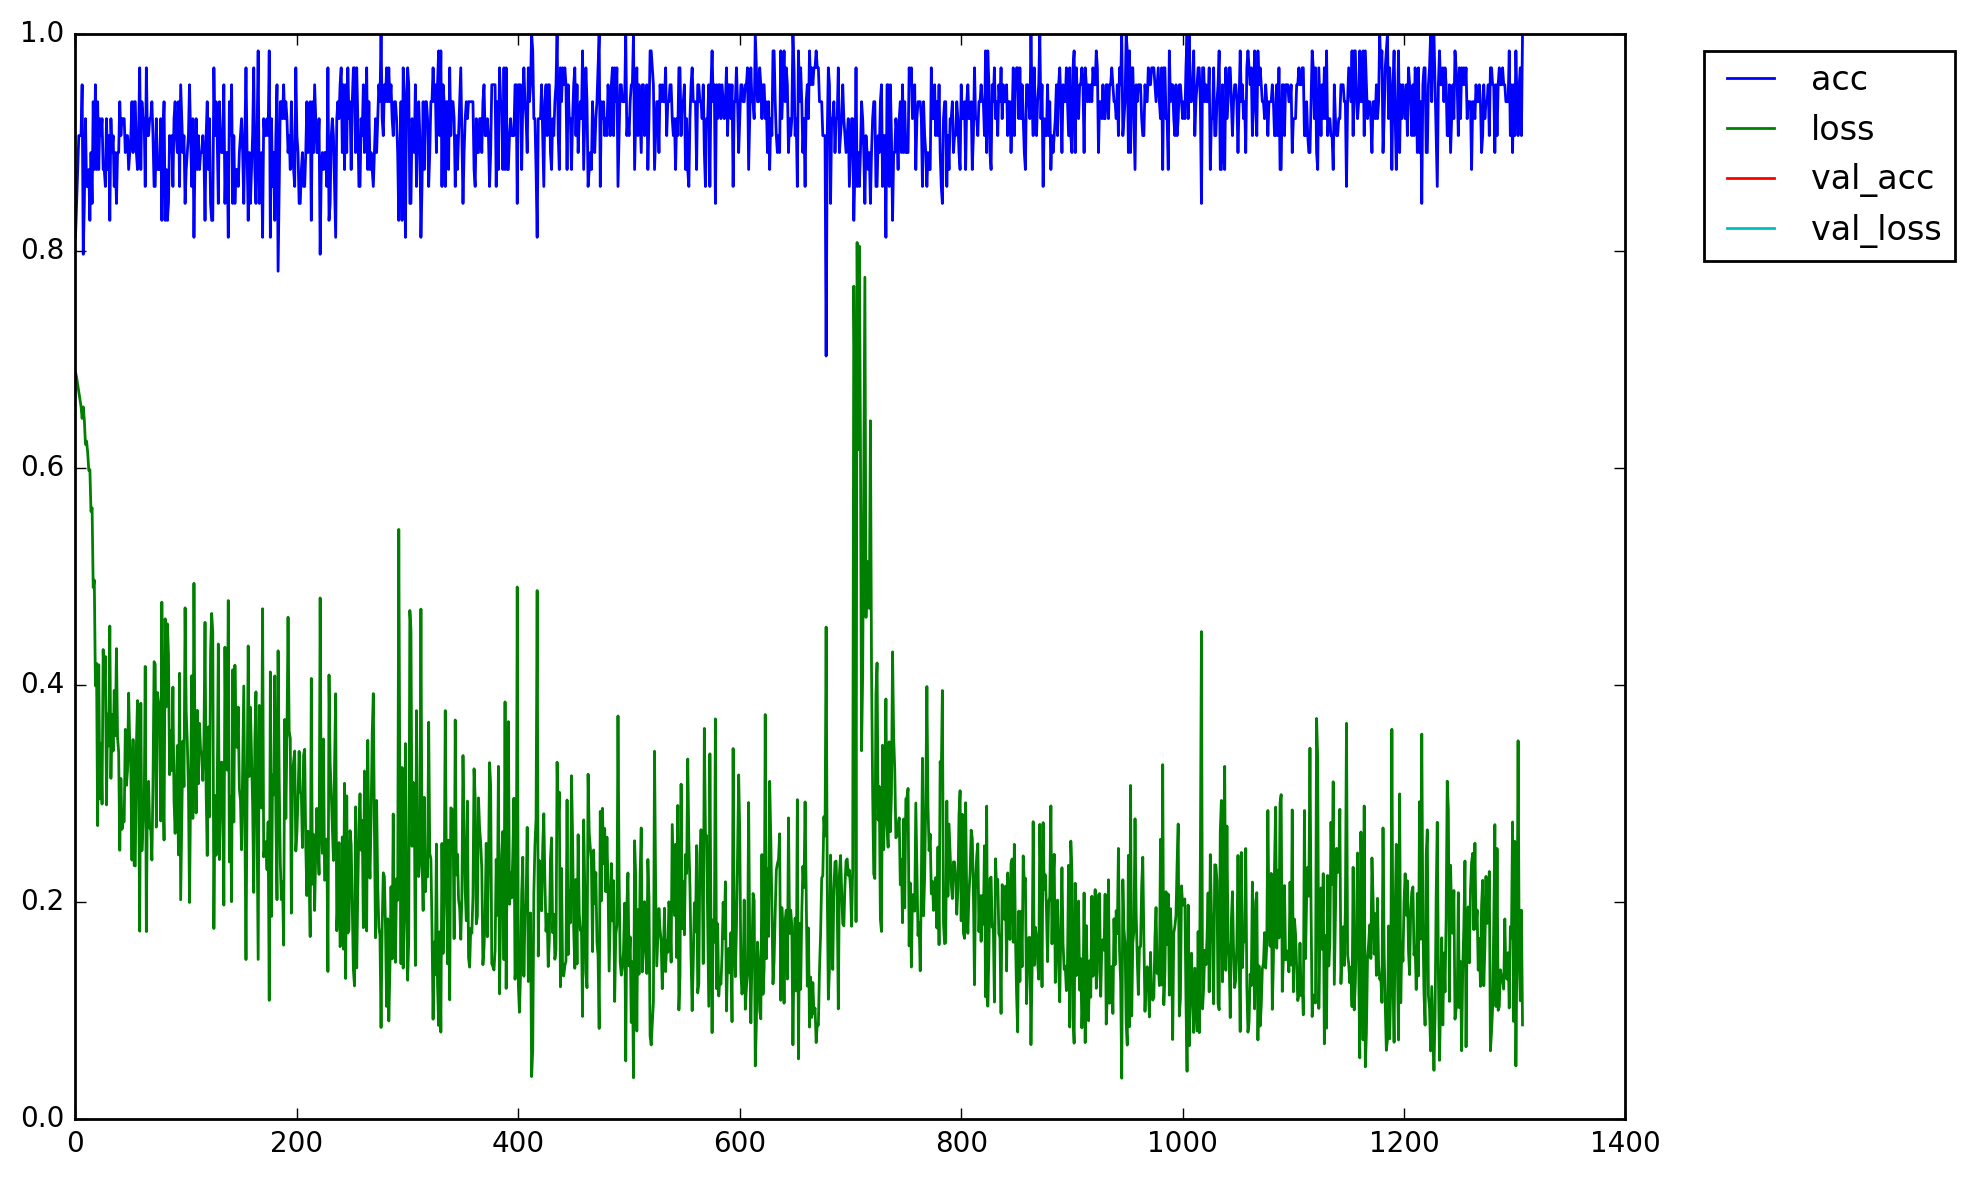

In [10]:
reload(util)
util.plot_genhistory(genhistory)

# 2x 1D Conv + LSTM

In [106]:
model = Sequential()
model.add(Conv1D(input_shape = (max_size,100), filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_rate))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_rate))
model.add(LSTM(100))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 110, 32)           9632      
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 55, 32)            0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 55, 32)            0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 55, 32)            3104      
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 27, 32)            0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 27, 32)            0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 100)               53200     
__________

In [107]:
optimizer = Adam(lr=5e-4, decay=0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
genhistory = util.GenHistory()
history = model.fit(X_train, y_train, class_weight = class_rebalance,
                      validation_data=(X_test, y_test), 
                      epochs=3, batch_size=64, verbose = 1,
                      callbacks = [genhistory])

Train on 55927 samples, validate on 27547 samples
Epoch 1/3
55927/55927 [==============================] - 80s - loss: 0.3707 - acc: 0.8449 - val_loss: 0.3175 - val_acc: 0.8543
Epoch 2/3
55927/55927 [==============================] - 77s - loss: 0.3235 - acc: 0.8537 - val_loss: 0.3087 - val_acc: 0.8606
Epoch 3/3
55927/55927 [==============================] - 76s - loss: 0.3151 - acc: 0.8594 - val_loss: 0.3078 - val_acc: 0.8584


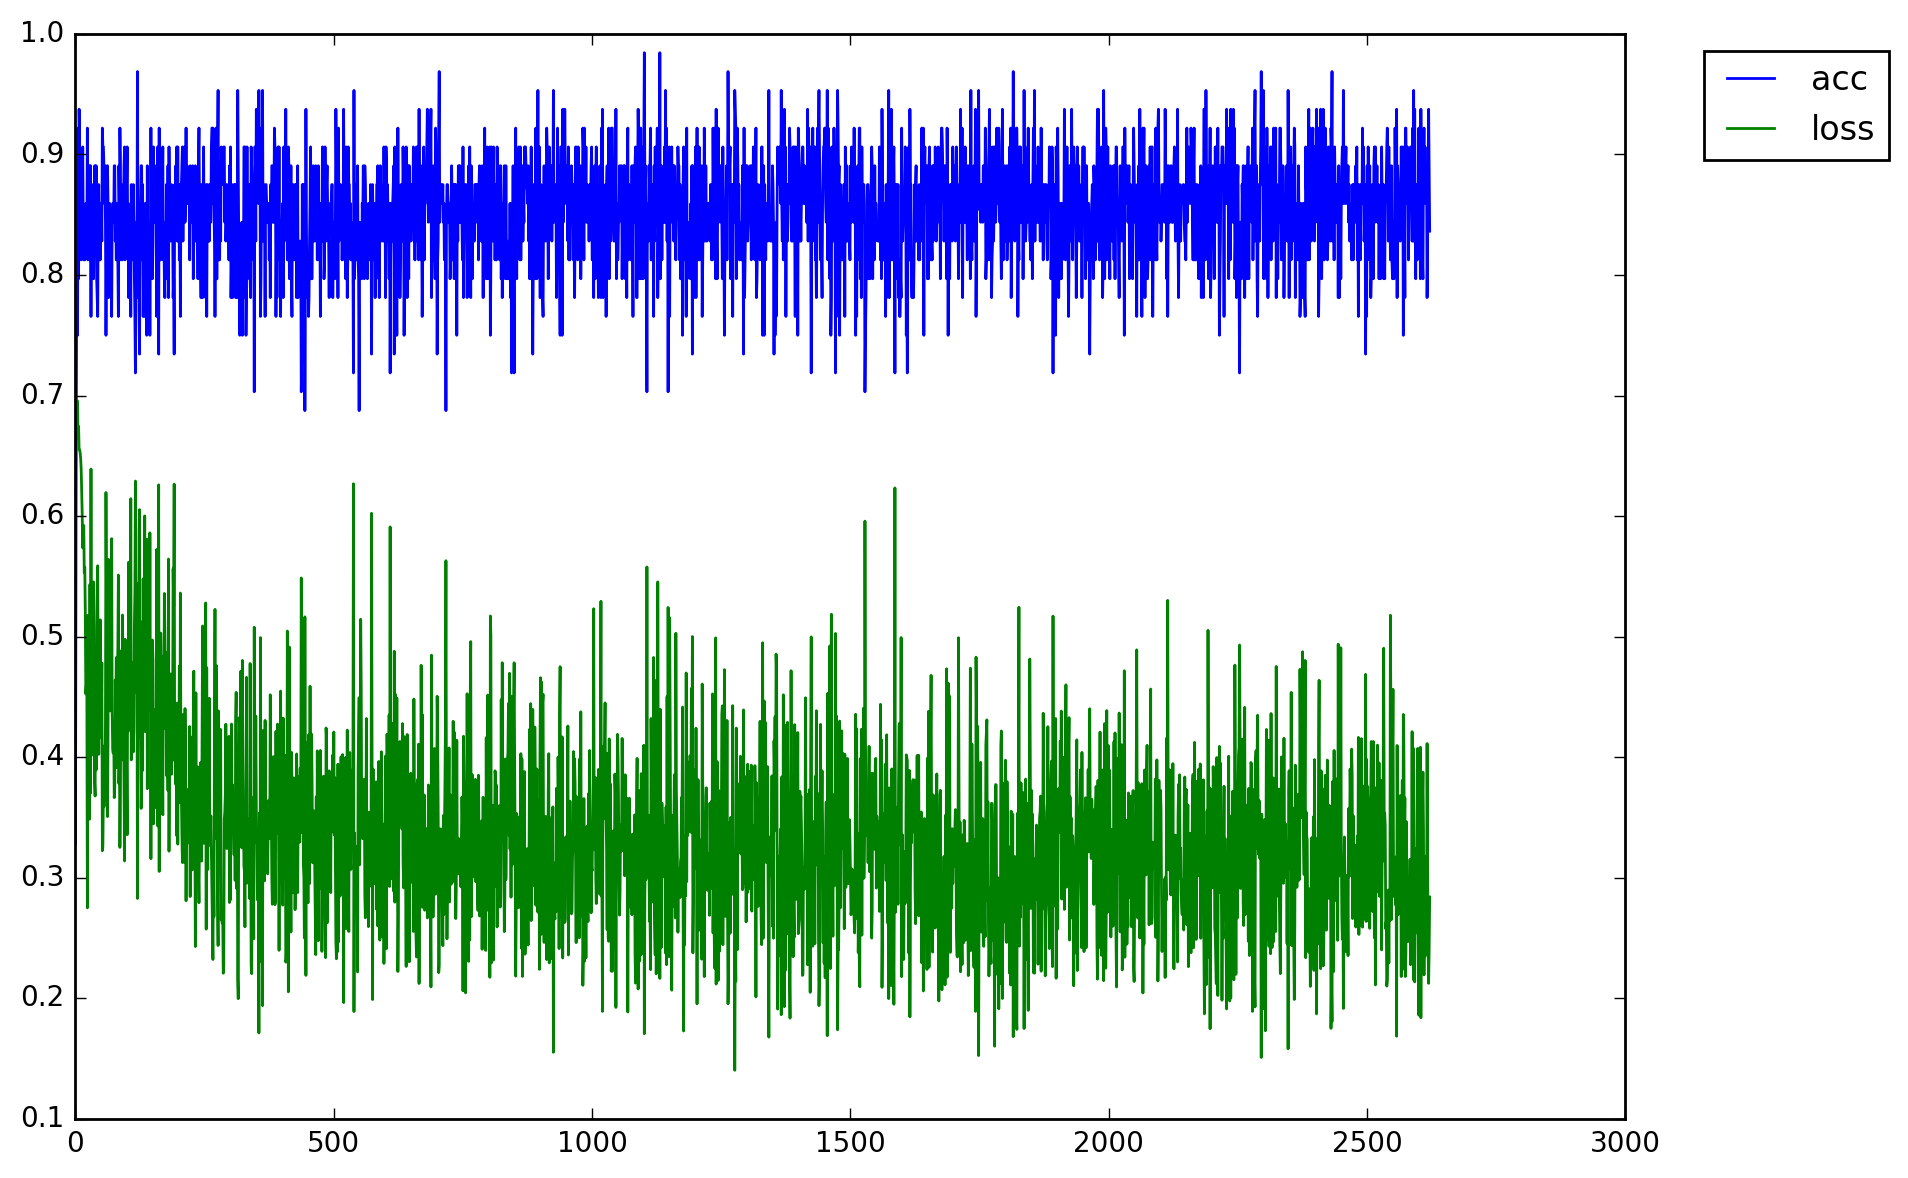

In [108]:
reload(util)
util.plot_genhistory(genhistory)

# Conv1d BLSTM 

In [36]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_rate))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_rate))
model.add(Bidirectional(LSTM(200)))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-4, decay=0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
genhistory = util.GenHistory()
history = model.fit(X_train, y_train, class_weight = class_rebalance,
                      validation_data=(X_test, y_test), 
                      epochs=10, batch_size=128, verbose = 1,
                      callbacks = [genhistory])

Train on 27842 samples, validate on 13714 samples
Epoch 1/10
27842/27842 [==============================] - 244s - loss: 0.3920 - acc: 0.8844 - val_loss: 0.3516 - val_acc: 0.8954
Epoch 2/10
27842/27842 [==============================] - 244s - loss: 0.3239 - acc: 0.8948 - val_loss: 0.3251 - val_acc: 0.8954
Epoch 3/10
27842/27842 [==============================] - 248s - loss: 0.2504 - acc: 0.8982 - val_loss: 0.2293 - val_acc: 0.9063
Epoch 4/10
27842/27842 [==============================] - 244s - loss: 0.1868 - acc: 0.9274 - val_loss: 0.2089 - val_acc: 0.9274
Epoch 5/10
27842/27842 [==============================] - 242s - loss: 0.1606 - acc: 0.9376 - val_loss: 0.2042 - val_acc: 0.9299
Epoch 6/10
27842/27842 [==============================] - 242s - loss: 0.1418 - acc: 0.9446 - val_loss: 0.2186 - val_acc: 0.9174
Epoch 7/10
27842/27842 [==============================] - 242s - loss: 0.1286 - acc: 0.9492 - val_loss: 0.2076 - val_acc: 0.9291
Epoch 8/10
27842/27842 [=======================

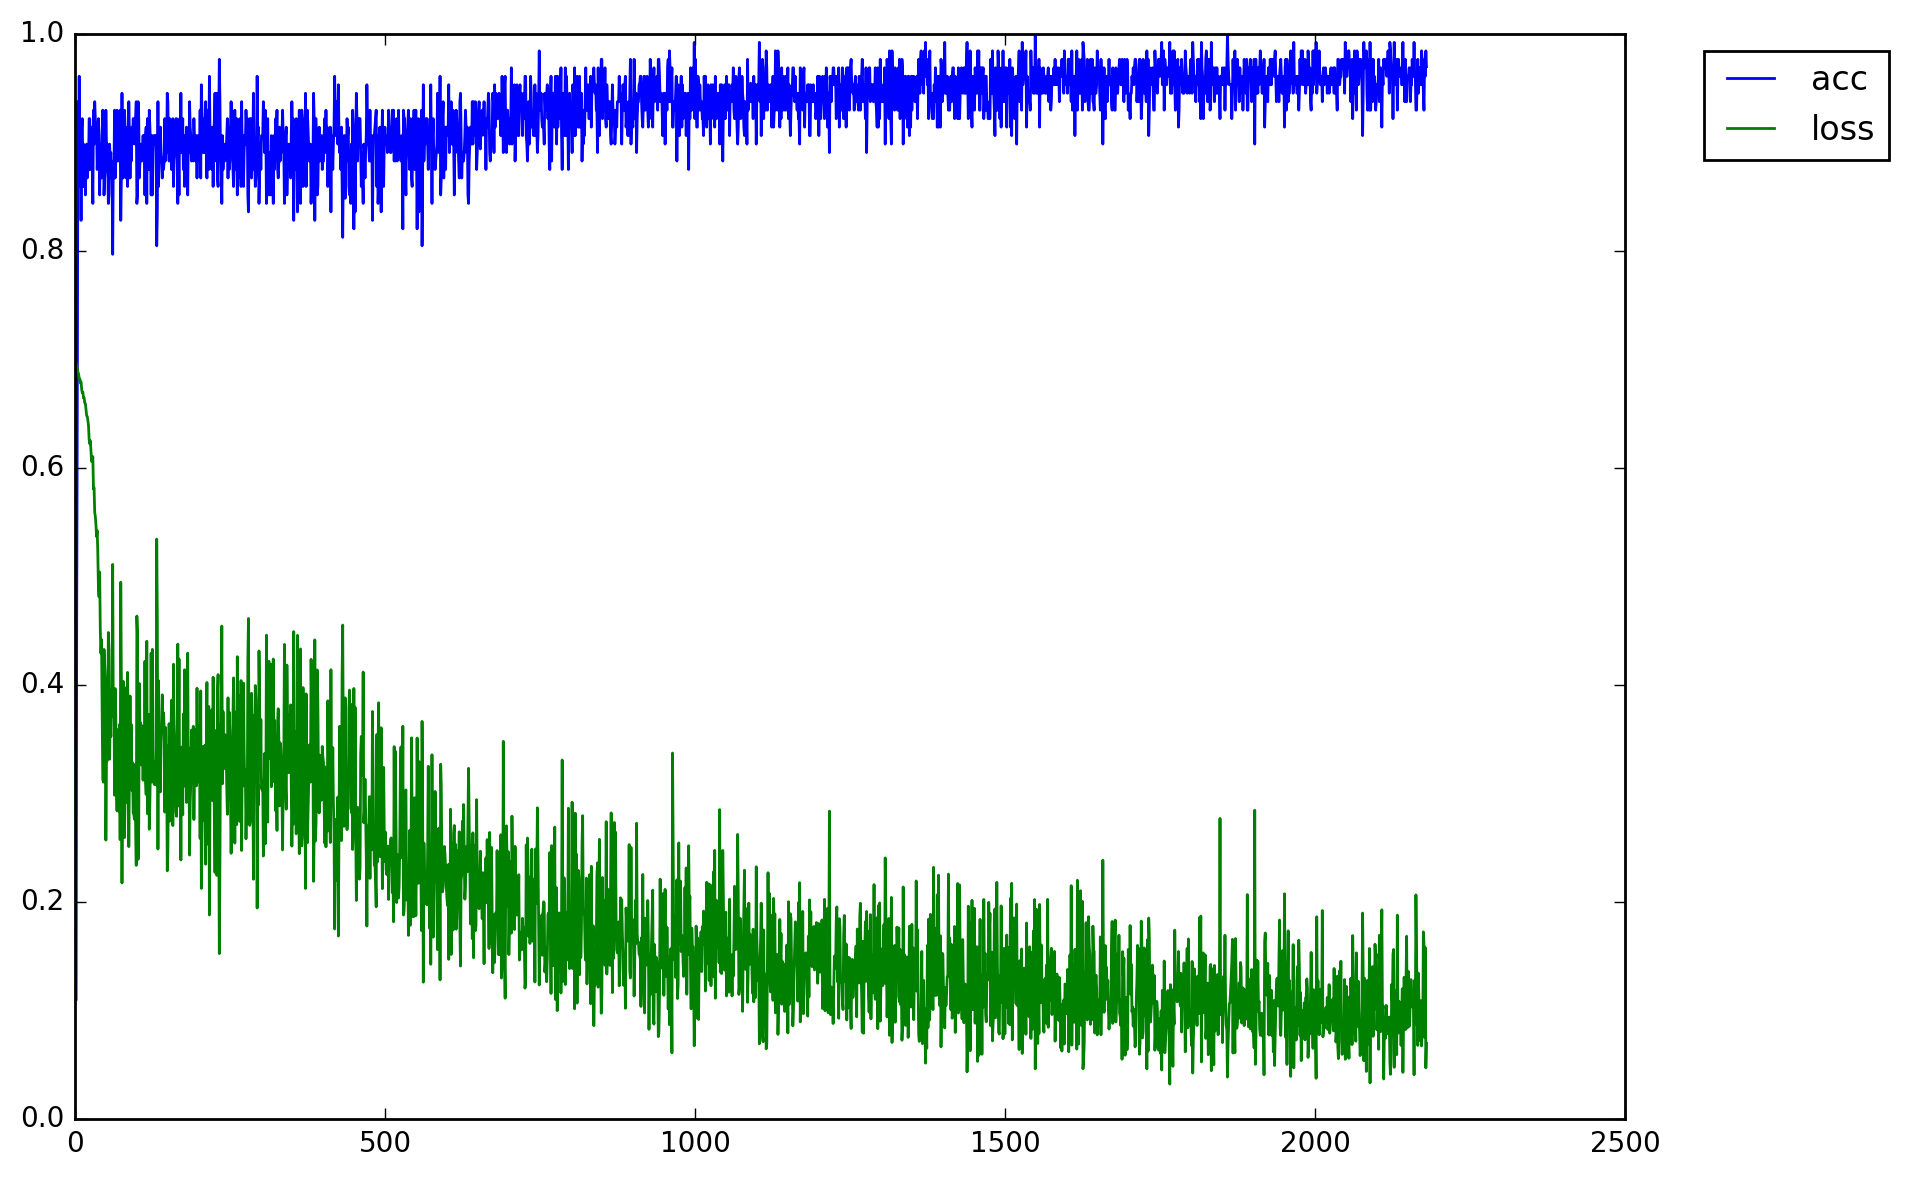

In [37]:
reload(util)
util.plot_genhistory(genhistory)

# Conv1d LSTM 

In [40]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_rate))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_rate))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-4, decay=0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
genhistory = util.GenHistory()
history = model.fit(X_train, y_train, class_weight = class_rebalance,
                      validation_data=(X_test, y_test), 
                      epochs=10, batch_size=128, verbose = 1,
                      callbacks = [genhistory])

Train on 27842 samples, validate on 13714 samples
Epoch 1/10
27842/27842 [==============================] - 146s - loss: 0.4155 - acc: 0.8780 - val_loss: 0.3342 - val_acc: 0.8954
Epoch 2/10
27842/27842 [==============================] - 151s - loss: 0.3292 - acc: 0.8948 - val_loss: 0.3293 - val_acc: 0.8954
Epoch 3/10
27842/27842 [==============================] - 144s - loss: 0.2735 - acc: 0.8951 - val_loss: 0.2349 - val_acc: 0.8991
Epoch 4/10
27842/27842 [==============================] - 149s - loss: 0.1945 - acc: 0.9205 - val_loss: 0.2042 - val_acc: 0.9263
Epoch 5/10
27842/27842 [==============================] - 151s - loss: 0.1618 - acc: 0.9373 - val_loss: 0.1987 - val_acc: 0.9288
Epoch 6/10
27842/27842 [==============================] - 144s - loss: 0.1411 - acc: 0.9461 - val_loss: 0.1992 - val_acc: 0.9288
Epoch 7/10
27842/27842 [==============================] - 147s - loss: 0.1248 - acc: 0.9524 - val_loss: 0.2000 - val_acc: 0.9339
Epoch 8/10
27842/27842 [=======================

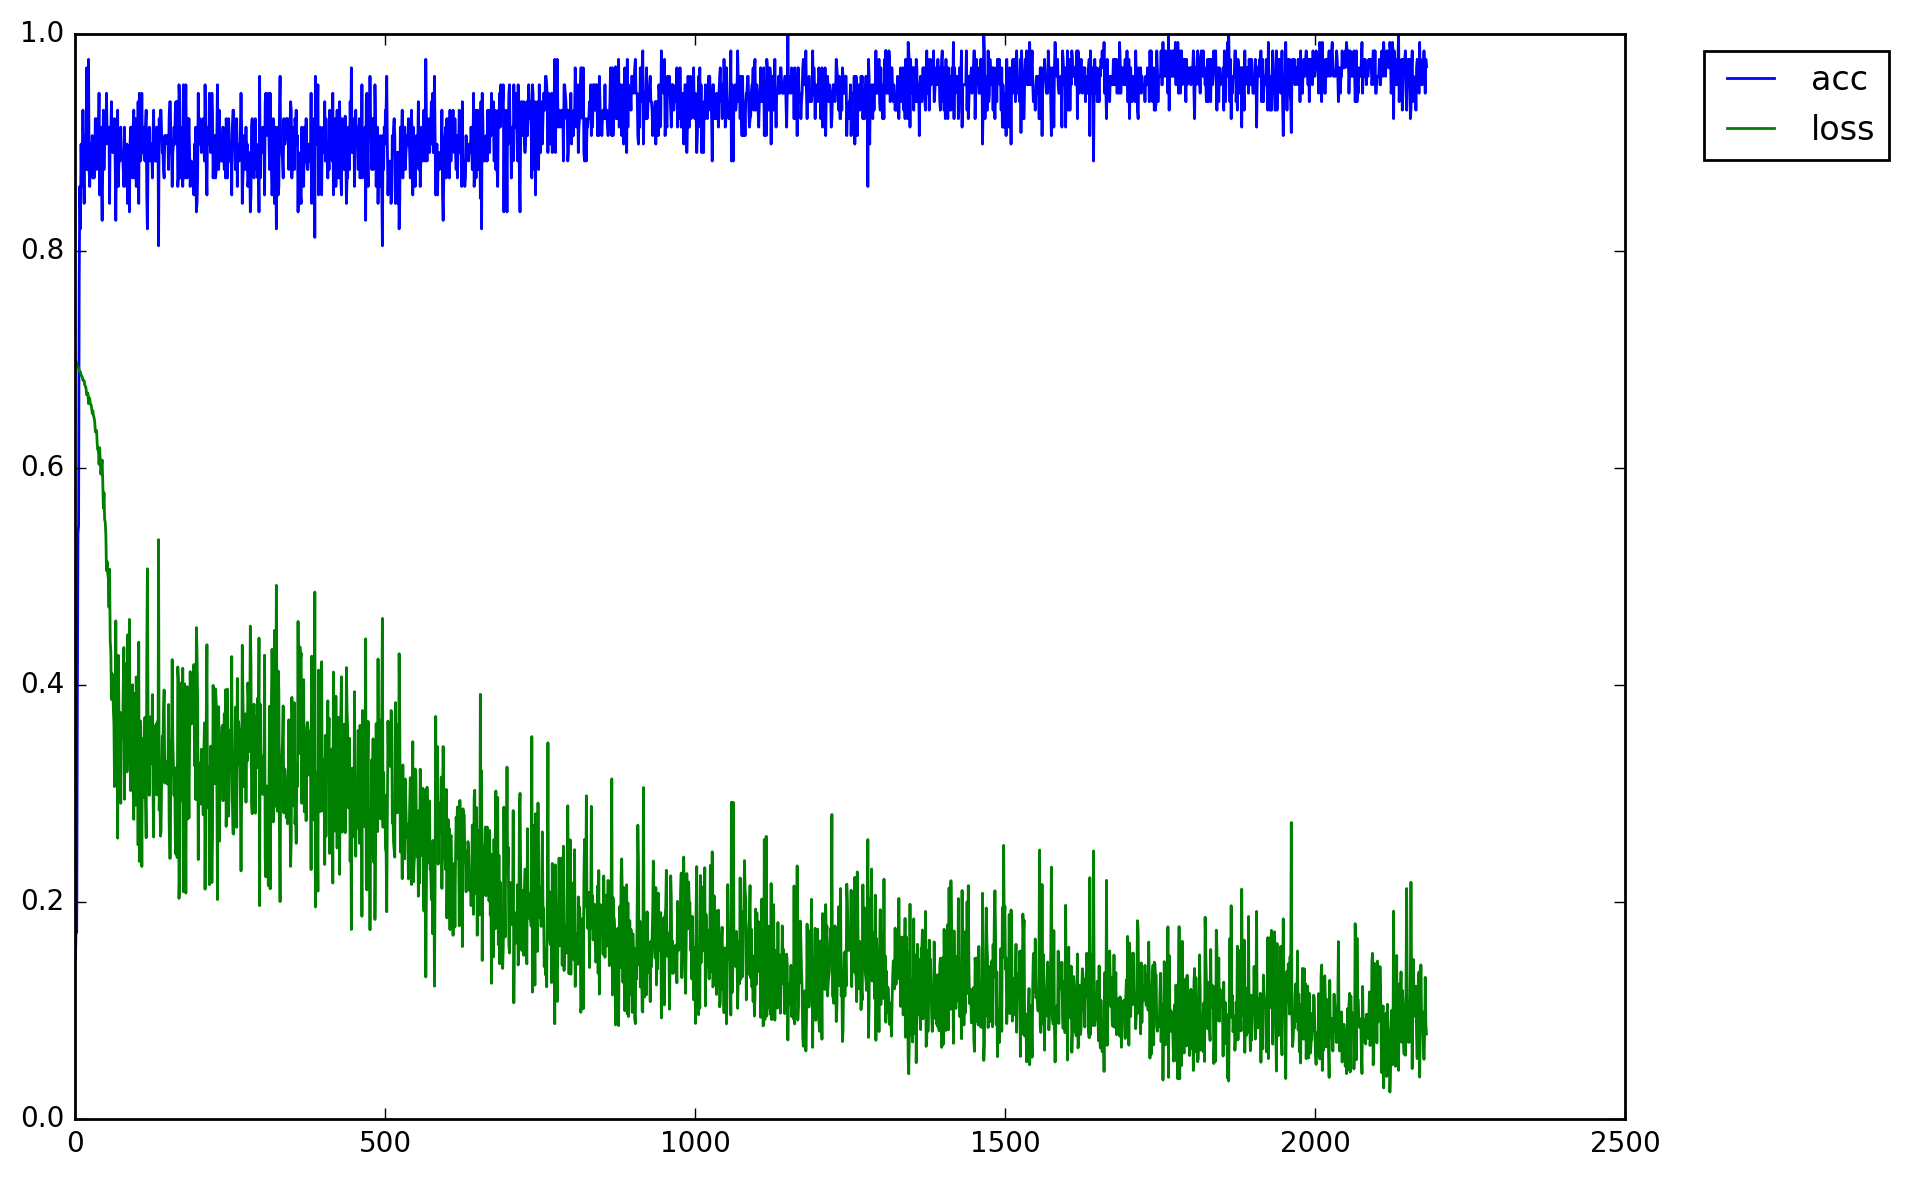

In [41]:
reload(util)
util.plot_genhistory(genhistory)

# Tail Model

In [72]:
# model = Sequential()
# model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(dropout_rate))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(dropout_rate))
# model.add(LSTM(100))
# model.add(Dense(1, activation='sigmoid'))

########
embedding_vector_length = 50

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_review_length,), dtype='int32')

# this embedding layer will transform the sequences of integers
# into vectors of size 256
embedded = Embedding(vocab_size, embedding_vector_length, input_length=max_review_length)(sequence)

# apply forwards LSTM
forwards = LSTM(100, return_sequences=True)(embedded)
# apply backwards LSTM
backwards = LSTM(100, return_sequences=True, go_backwards=True)(embedded)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
last_lstm = LSTM(100)(merged)
after_dp = Dropout(dropout_rate)(last_lstm)

output = Dense(output_dim=1, activation='softmax')(after_dp)
model = Model(input=sequence, output=output)
print model.summary()
######

# left = Sequential()
# left.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
# left.add(LSTM(100))

# right = Sequential()
# right.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
# right.add(LSTM(100))

# print right.summary()
# model = Sequential()
# model.add(Merge([left,right]))
# model.add(Dense(1, activation='sigmoid'))
# print model.summary()



optimizer = Adam(lr=1e-4, decay=0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
genhistory = util.GenHistory()
history = model.fit(X_train, y_train, class_weight = class_rebalance,
                      validation_data=(X_test, y_test), 
                      epochs=3, batch_size=128, verbose = 1,
                      callbacks = [genhistory])

/home/efs/nds.locus.io/berden/code/env/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/efs/nds.locus.io/berden/code/env/lib/python2.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, activation="softmax")`
/home/efs/nds.locus.io/berden/code/env/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 500)           0                                            
____________________________________________________________________________________________________
embedding_55 (Embedding)         (None, 500, 50)       2500000     input_17[0][0]                   
____________________________________________________________________________________________________
lstm_56 (LSTM)                   (None, 500, 100)      60400       embedding_55[0][0]               
____________________________________________________________________________________________________
lstm_57 (LSTM)                   (None, 500, 100)      60400       embedding_55[0][0]               
___________________________________________________________________________________________

KeyboardInterrupt: 

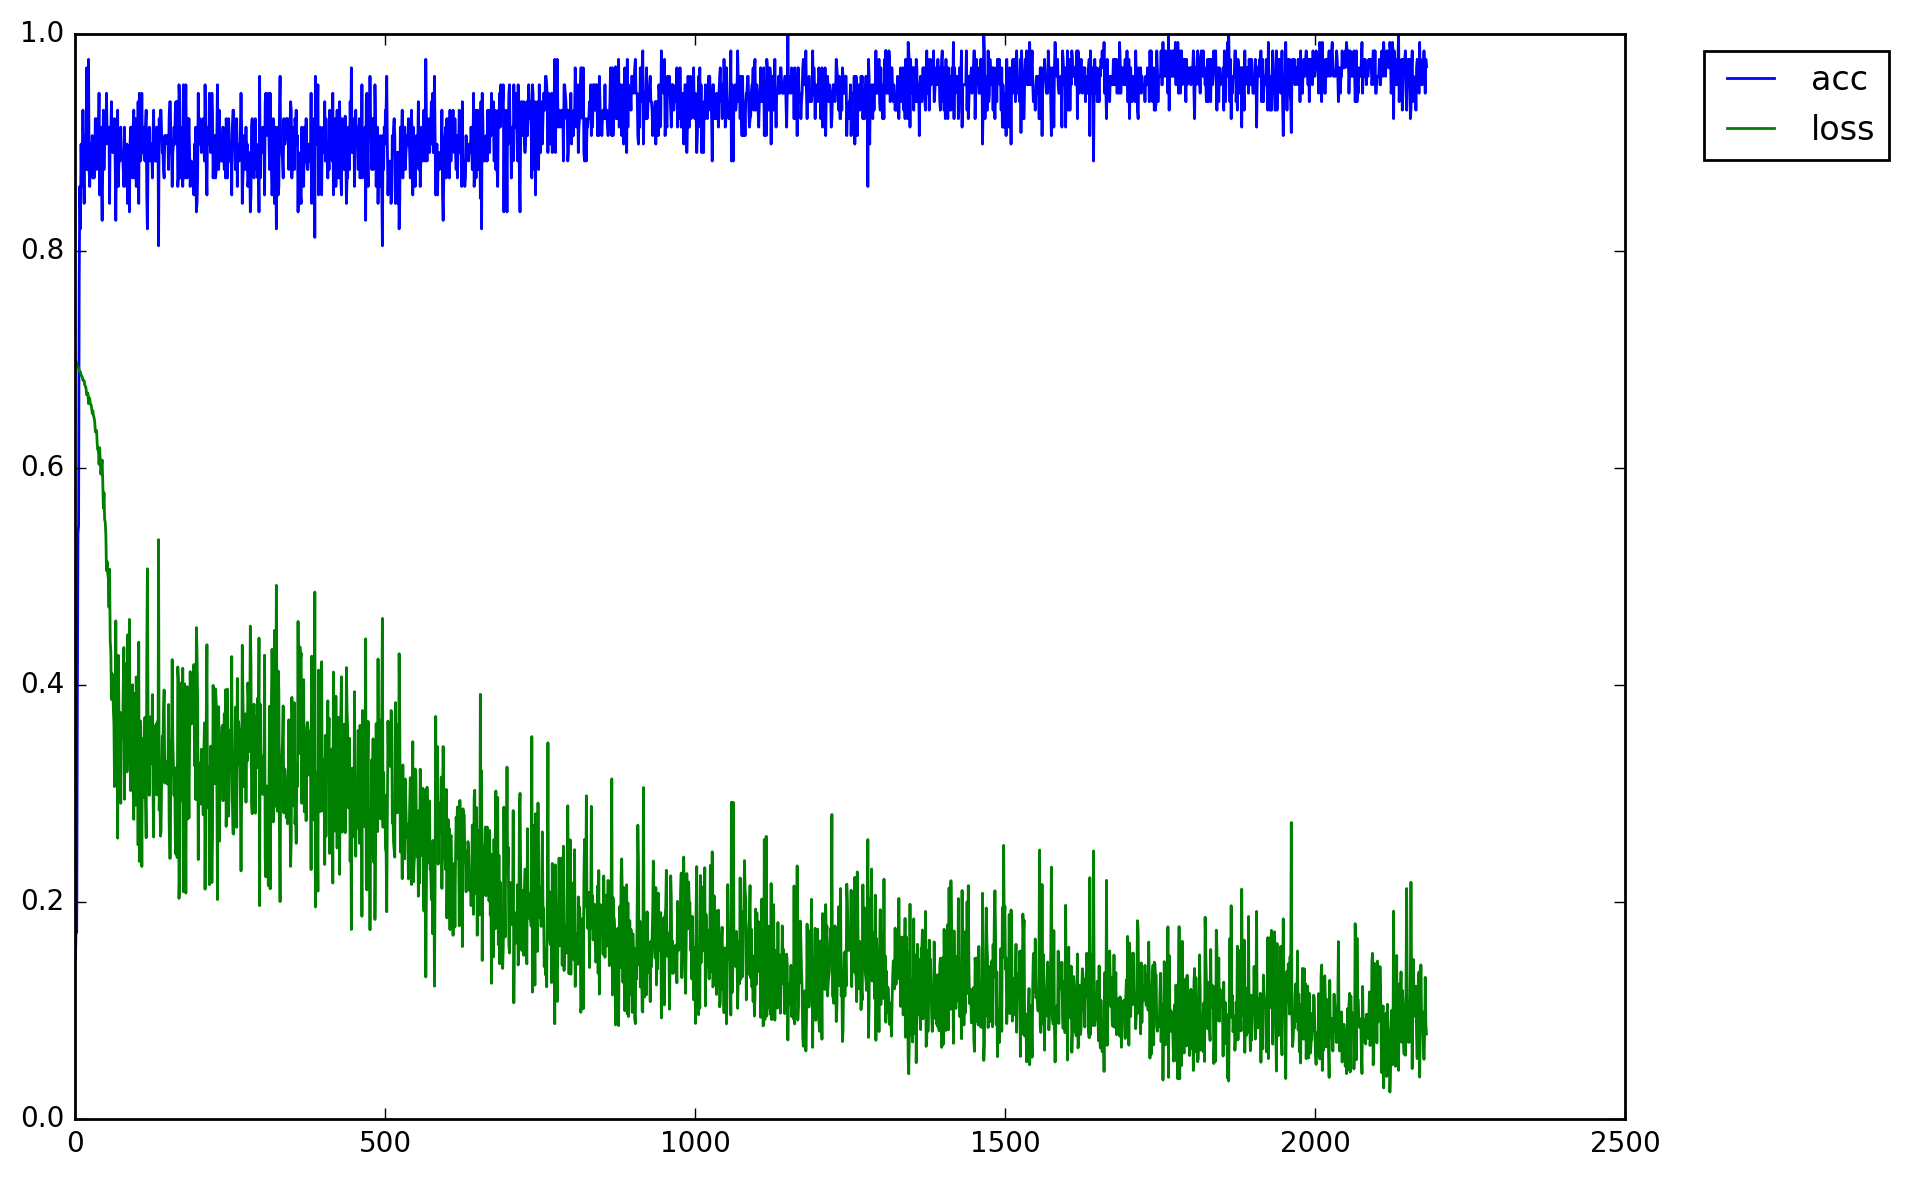

In [41]:
reload(util)
util.plot_genhistory(genhistory)